# FA7 - AES 128 DFA on real target

With this exercise, you will practice fault injection on a real target doing AES 128 encryption.

# Challenge

Retrieve the AES key used to encrypt the data

### Characterization

To characterize the best parameters, you will have to glitch a simple function which counts up to 2500. If the right parameters are set, the device should reply with a value different than that.

### Attack

To attack this implementation, you have several options :

 - Attacks on the 8th round of AES
 - Attacks on the 9th round of AES (See the slides about fault propagation to see the patterns)
 - Attacks on the 10th round, before the SBox operation
 - Attacks on the 10th round, during the last AddRoundKey

Some of the attacks are implemented in the [phoenixAES](https://github.com/SideChannelMarvels/JeanGrey) library

In [25]:
#Imports

import chipwhisperer as cw
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
import glob
import seaborn as sns
import phoenixAES
import sca_training
import binascii

In [3]:
# Chipwhisperer basic configuration

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial2)
prog = cw.programmers.STM32FProgrammer
scope.default_setup()

#Chipwhisperer clock is fed to the target chip
scope.clock.clkgen_freq = 24E6
target.baud = 230400*24/7.37

cw.set_all_log_levels(cw.logging.CRITICAL)

# Already decimate the ADC samples. This way, ext_offset matches the ADC samples
scope.adc.samples = 8000
scope.adc.decimate = 4

In [4]:
#Helper functions

def target_reset():
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)
    target.flush()


In [5]:
#Test that everything goes well by sending the loop command and check its output

target_reset()
scope.arm()
target.simpleserial_write("g", bytearray([]))
scope.capture()
val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)
# Should print
# {'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': CWbytearray(b'00 72 04 c4 09 00 00 15 00'), 'rv': bytearray(b'\x00')}

{'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': CWbytearray(b'00 72 04 c4 09 00 00 15 00'), 'rv': bytearray(b'\x00')}


In [6]:
#Encrypt a plaintext and retrieve the ciphertext
# This can be used as your reference ciphertext for further attacks

target_reset()
scope.arm()
target.simpleserial_write("p", b'0123456789abcdef')
scope.capture()
val = target.simpleserial_read_witherrors('r', 16, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    print(response)
    CLEAN_CIPHERTEXT = response


CWbytearray(b'cd 8f e4 fa ee 3e b0 ce bf 2d 4f eb 3d fa 2e cb')


In [7]:
# print password and response as a hex string
password = "0123456789abcdef"
password = password.encode("utf-8").hex()
print(password)
print("".join("{:02x}".format(x) for x in response))

30313233343536373839616263646566
cd8fe4faee3eb0cebf2d4feb3dfa2ecb


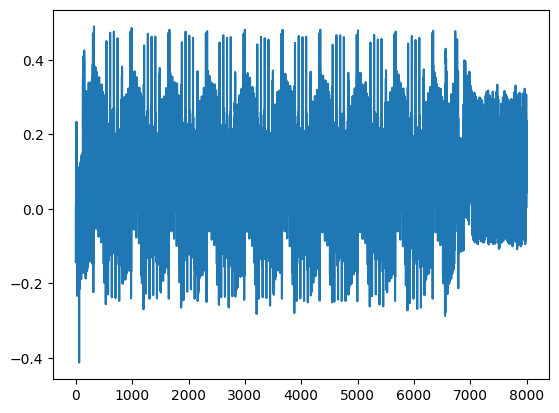

In [8]:
# For the last encryption, show the associated power trace
plt.plot(scope.get_last_trace())

In [9]:
#Basic glitch settings

scope.glitch.clk_src = "clkgen" # glitch counters use the main clock (24MHz)
scope.glitch.output = "glitch_only" # Glitch output signal
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
scope.io.glitch_lp = True # Enable low power MOSFET
scope.io.glitch_hp = True # Enable high power MOSFET
scope.glitch.repeat = 7 # Number of successive glitches, 7 should be OK for our target

In [ ]:
# Characterization loop

# Thic block will iterate over some of the glitch parameters to locate the "sweet spot"
# where the glitches produce an effect

# Change this block accordingly in order to find the parameters that produce
# the maximum amount of glitches before going further the template

# ext_offset is the number of clock cycles after the trigger

def characterize_chip(offset_min: float, offset_max: float, offset_step: float, width_min: float, width_max: float, width_step: float, save_to_file: bool = False, show_progress: bool = True):
  df = pd.DataFrame(columns=['offset','width', 'count'])

  offsets = np.arange(offset_min, offset_max, offset_step)
  widths = np.arange(width_min, width_max, width_step)

  for ext_offset in range(1,2):
      scope.glitch.ext_offset = ext_offset
      
      # offset is the percentage into the clock cycle where the glitch starts
     
      progress_offsets = tqdm(offsets, desc="Offset", position=0, disable=not show_progress)

      for offset in progress_offsets:
        scope.glitch.offset = offset
          # progress_offsets.set_description(f"Offset {offset:0.2f}")
          

          # Width is the percentage of the period to glitch
          
        progress_widths = tqdm(widths, desc="Width", position=1, leave=False, disable=not show_progress)
        for width in progress_widths:
            scope.glitch.width = width
            # progress_widths.set_description(f"Width {width:0.2f}")
            
            # Repeat each iteration 5 times to ensure we get consistant results
            count = 0
            for _ in range(5):
                
                #Fun starts here
                target_reset()
                scope.arm()
                target.simpleserial_write("g", bytearray([]))
                ret = scope.capture()
                #scope.io.vglitch_reset()
                
                # read response from target
                val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10, timeout=30)
                
                # If no response from the chip, assume it crashed
                if val['valid'] is False:
                    # print("X", end="")
                    continue
                
                # if counter is different thant the correct value, print the results
                counter = int.from_bytes(val['payload'], byteorder='little')
                if counter != 2500:
                    count += 1
                    # print(f"*{counter:08d}*", end="")
                    
                # else:
                    # print(".", end="")
            if count > 0:
                # print()
                # print(f"Count {count:02d}\text_offset {ext_offset:02d}\tWidth {width:0.2f}\tOffset {offset:0.2f}")
                df.loc[len(df.index)] = [offset, width, count]
        if save_to_file and not df.empty:
          df.to_csv(f"data/offset_{offset}.csv")
          df = pd.DataFrame(columns=['offset','width', 'count'])
  return df

In [ ]:
df = characterize_chip(-23.8, -19.3, 0.2, 35.3, 35.8, 0.1, save_to_file=True, show_progress=True)

In [10]:
# Load result file
res_files = glob.iglob("data/[!merged]*.csv")
merged_data = pd.DataFrame(columns=['offset','width', 'count'])
merged_data = pd.concat(map(pd.read_csv, res_files), ignore_index= True).drop(columns=['Unnamed: 0'])
merged_data = merged_data.round(2)
merged_data.to_csv("data/merged.csv")
print(merged_data)

     offset  width  count
0     -19.6   35.3    5.0
1     -19.6   35.4    2.0
2     -19.6   35.5    3.0
3     -19.6   35.6    2.0
4     -19.6   35.7    2.0
..      ...    ...    ...
105   -19.8   35.3    4.0
106   -19.8   35.4    4.0
107   -19.8   35.5    3.0
108   -19.8   35.6    5.0
109   -19.8   35.7    5.0

[110 rows x 3 columns]


<Axes: xlabel='width', ylabel='offset'>

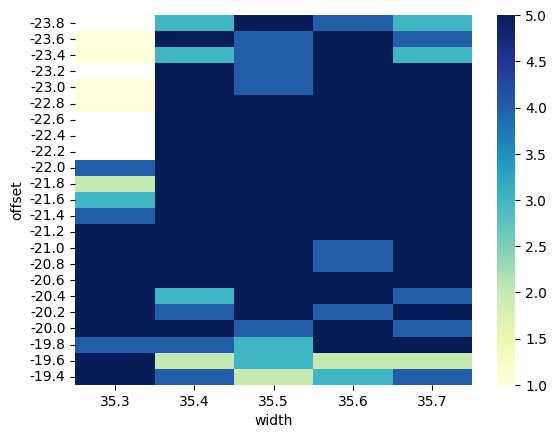

In [11]:
sns.heatmap(merged_data.pivot(index="offset", columns="width", values="count"), annot=False, fmt="g", cmap="YlGnBu")

In [21]:
found_xor = np.zeros((22), dtype=bytes)
found_fciphers = np.zeros((22), dtype=bytes)

# ext_offset is the number of clock cycles after the trigger
for ext_offset in range(5700,6500): #set ext_offset to reach the desired round
    scope.glitch.ext_offset = ext_offset
    
    # offset is the percentage into the clock cycle where the glitch starts
    for offset in np.arange(-23.0, -22.0, 0.2): 
        scope.glitch.offset = offset
        
        # Width is the percentage of the period to glitch
        for width in  np.arange(35.4, 35.8, 0.2):
            scope.glitch.width = width

            for _ in range(7):

                #Fun starts here

                target_reset()
                scope.arm()
                # Send dummy password
                target.simpleserial_write("p", b'0123456789abcdef')
                ret = scope.capture()

                val = target.simpleserial_read_witherrors('r', 16, glitch_timeout=10, timeout=30)
                if val['valid'] is False:
                    print("X", end="")
                    continue

                result = val['payload']
                if result != CLEAN_CIPHERTEXT:
                    xor = bytes(a ^ b for (a, b) in zip(CLEAN_CIPHERTEXT, result))
                    print()
                    print(f"ext_offset {ext_offset:02d}\tWidth {width:0.2f}\tOffset {offset:0.2f}\tResult {result.hex()}\txor: {xor.hex()}")
                    # check if xor is diagonal
                    if xor.count(b'\x00') == 12 and xor not in found_xor:
                        found_xor = np.append(found_xor, xor)
                        found_fciphers = np.append(found_fciphers, result)
                        print("Found xor", xor.hex())

                    try:
                        print(result.decode())
                    except:
                        pass

                else:
                    print(".", end="")


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
ext_offset 5709	Width 35.40	Offset -23.00	Result 198fe4faee3eb0f4bf2d95eb3db02ecb	xor: d40000000000003a0000da00004a0000
Found xor d40000000000003a0000da00004a0000

ext_offset 5709	Width 35.40	Offset -23.00	Result 198fe4faee3eb0f4bf2d95eb3db02ecb	xor: d40000000000003a0000da00004a0000

ext_offset 5709	Width 35.40	Offset -23.00	Result 198fe4faee3eb0f4bf2d95eb3db02ecb	xo

KeyboardInterrupt: 

In [22]:
with open('tracefile', 'wb') as t:
    t.write("""
30313233343536373839616263646566 cd8fe4faee3eb0cebf2d4feb3dfa2ecb
30313233343536373839616263646566 198fe4faee3eb0f4bf2d95eb3db02ecb
30313233343536373839616263646566 d08fe4faee3eb035bf2df1eb3d362ecb
30313233343536373839616263646566 d88fe4faee3eb053bf2d41eb3dcd2ecb
30313233343536373839616263646566 738fe4faee3eb0babf2dd5eb3d342ecb
30313233343536373839616263646566 cd4ae4fabf3eb0cebf2d4fb53dfafacb
30313233343536373839616263646566 cddde4fa523eb0cebf2d4f4e3dfaf9cb
30313233343536373839616263646566 cd44e4fadf3eb0cebf2d4f363dfa10cb
30313233343536373839616263646566 cd1de4fa103eb0cebf2d4fbd3dfa0bcb
30313233343536373839616263646566 cd8f68faeeb4b0ce9d2d4feb3dfa2e25
30313233343536373839616263646566 cd8f95faee35b0ce3c2d4feb3dfa2ec5
30313233343536373839616263646566 cd8fa9faee27b0ce8d2d4feb3dfa2e5c
30313233343536373839616263646566 cd8f2efaeecab0ce312d4feb3dfa2ec5
30313233343536373839616263646566 cd8fe43bee3e67cebfdf4feb72fa2ecb
30313233343536373839616263646566 cd8fe426ee3e87cebfe94feb53fa2ecb
30313233343536373839616263646566 a88fe4faee3eb07abf2db7eb3dbe2ecb
30313233343536373839616263646566 cc8fe4faee3eb073bf2dc9eb3d652ecb
30313233343536373839616263646566 598fe4faee3eb005bf2d75eb3d952ecb
30313233343536373839616263646566 cd3ce4faf13eb0cebf2d4f2c3dfa12cb
30313233343536373839616263646566 cd56e4fa6b3eb0cebf2d4fa33dfa32cb
30313233343536373839616263646566 cdece4fa963eb0cebf2d4f1c3dfa8dcb
30313233343536373839616263646566 cd8f07faee00b0cedc2d4feb3dfa2e45
30313233343536373839616263646566 cd8f0efaee81b0ce542d4feb3dfa2e18
""".encode('utf8'))

phoenixAES.crack_file('tracefile')

Last round key #N found:
969559CD3BD154F69F4EB2DC08359A64


'969559CD3BD154F69F4EB2DC08359A64'

In [30]:
#Get master key using the provided binary
k10 = b'\x96\x95\x59\xCD\x3B\xD1\x54\xF6\x9F\x4E\xB2\xDC\x08\x35\x9A\x64'
# convert from bytes to numpy array
k10 = np.frombuffer(k10, dtype=np.uint8)
key_schedule = sca_training.inverse_key_expansion(k10)
print(key_schedule.shape)

print('Master key in hex:', key_schedule[0,0,:])

print('Master key in ASCII:', binascii.unhexlify(''.join('{:02x}'.format(c) for c in key_schedule[0,0,:])))

(1, 11, 16)
Master key in hex: [ 72  69  73  71 123  82 101  97 108  65  69  83  49  50  56 125]
Master key in ASCII: b'HEIG{RealAES128}'


In [ ]:
scope.dis()